In [1]:
import math
import random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
# from torch.distributions import Categorical

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

<h2>Use CUDA</h2>

In [3]:
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

<h2>Replay Buffer</h2>

In [4]:
from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done, goal):
        self.buffer.append((state, action, reward, next_state, done, goal))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done, goal = zip(*random.sample(self.buffer, batch_size))
        return np.stack(state), action, reward, np.stack(next_state), done, np.stack(goal)
    
    def __len__(self):
        return len(self.buffer)

<h2>Bit Flipping Environment</h2>

In [5]:
class Env(object):
    def __init__(self, num_bits):
        self.num_bits = num_bits
    
    def reset(self):
        self.done      = False
        self.num_steps = 0
        self.state     = np.random.randint(2, size=self.num_bits)
        self.target    = np.random.randint(2, size=self.num_bits)
        return self.state, self.target
    
    def step(self, action):
        if self.done:
            # raise RESET
            return self.reset()
        
        self.state[action] = 1 - self.state[action]
        
        if self.num_steps > self.num_bits + 1:
            self.done = True
        self.num_steps += 1
        
        if np.sum(self.state == self.target) == self.num_bits:
            self.done = True
            return np.copy(self.state), 0, self.done, {}
        else:
            return np.copy(self.state), -1, self.done, {}

<h2>Neural Network</h2>

In [6]:
class Model(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size=256):
        super(Model, self).__init__()
        
        self.linear1 = nn.Linear(num_inputs,  hidden_size)
        self.linear2 = nn.Linear(hidden_size, num_outputs)
    
    def forward(self, state, goal):
        x = torch.cat([state, goal], 1)
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x
    
def update_target(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())

In [7]:
def get_action(model, state, goal, epsilon=0.1):
    if random.random() < 0.1:
        return random.randrange(env.num_bits)
    
    state = torch.FloatTensor(state).unsqueeze(0).to(device)
    goal  = torch.FloatTensor(goal).unsqueeze(0).to(device)
    q_value = model(state, goal)
    return q_value.max(1)[1].item()

In [8]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('Mean Reward: %s. frame: %s' % (rewards[-1], frame_idx))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

<h2>Q-learning TD Error</h2>

In [9]:
def compute_td_error(batch_size):
    if batch_size > len(replay_buffer):
        return None

    state, action, reward, next_state, done, goal = replay_buffer.sample(batch_size)

    state      = torch.FloatTensor(state).to(device)
    reward     = torch.FloatTensor(reward).unsqueeze(1).to(device)
    action     = torch.LongTensor(action).unsqueeze(1).to(device)
    next_state = torch.FloatTensor(next_state).to(device)
    goal       = torch.FloatTensor(goal).to(device)
    mask       = torch.FloatTensor(1 - np.float32(done)).unsqueeze(1).to(device)

    q_values = model(state, goal)
    q_value  = q_values.gather(1, action)

    next_q_values = target_model(next_state, goal)
    target_action = next_q_values.max(1)[1].unsqueeze(1)
    next_q_value  = target_model(next_state, goal).gather(1, target_action)

    expected_q_value = reward + 0.99 * next_q_value * mask

    loss = (q_value - expected_q_value.detach()).pow(2).mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

<h1>DQN without Hindsight Experience Replay</h1>

In [10]:
num_bits = 11
env = Env(num_bits)

model        = Model(2 * num_bits, num_bits).to(device)
target_model = Model(2 * num_bits, num_bits).to(device)
update_target(model, target_model)

#hyperparams:
batch_size = 5
new_goals  = 5
max_frames = 200000
    
optimizer = optim.Adam(model.parameters())
replay_buffer = ReplayBuffer(10000)

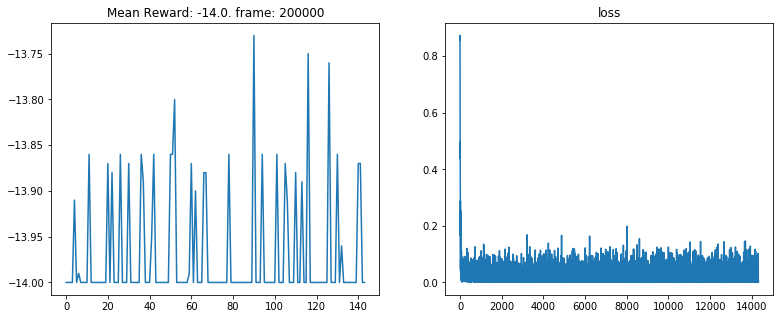

In [12]:
frame_idx = 0
all_rewards = []
losses = []

while frame_idx < max_frames:
    state, goal = env.reset()
    done = False
    episode = []
    total_reward = 0
    while not done:
        action = get_action(model, state, goal)
        next_state, reward, done, _ = env.step(action)
        replay_buffer.push(state, action, reward, next_state, done, goal)
        state = next_state
        total_reward += reward
        frame_idx += 1
        
        if frame_idx % 1000 == 0:
            plot(frame_idx, [np.mean(all_rewards[i:i+100]) for i in range(0, len(all_rewards), 100)], losses)
        
    all_rewards.append(total_reward)
    
    loss = compute_td_error(batch_size)
    if loss is not None: losses.append(loss.data.item())

<h1> Hindsight Experience Replay <a href="https://arxiv.org/abs/1707.01495">[arxiv]</a></h1>
<h2><a href="https://blog.openai.com/ingredients-for-robotics-research/#understandingher">OpenAI Blog:</a> Understanding HER</h2>
<p>To understand what HER does, let’s look at in the context of FetchSlide, a task where we need to learn to slide a puck across the table and hit a target. Our first attempt very likely will not be a successful one. Unless we get very lucky, the next few attempts will also likely not succeed. Typical reinforcement learning algorithms would not learn anything from this experience since they just obtain a constant reward (in this case: -1) that does not contain any learning signal.</p>

<p>The key insight that HER formalizes is what humans do intuitively: Even though we have not succeeded at a specific goal, we have at least achieved a different one. So why not just pretend that we wanted to achieve this goal to begin with, instead of the one that we set out to achieve originally? By doing this substitution, the reinforcement learning algorithm can obtain a learning signal since it has achieved some goal; even if it wasn’t the one that we meant to achieve originally. If we repeat this process, we will eventually learn how to achieve arbitrary goals, including the goals that we really want to achieve.</p>

<p>This approach lets us learn how to slide a puck across the table even though our reward is fully sparse and even though we may have never actually hit the desired goal early on. We call this technique Hindsight Experience Replay since it replays experience (a technique often used in off-policy RL algorithms like DQN and DDPG) with goals which are chosen in hindsight, after the episode has finished. HER can therefore be combined with any off-policy RL algorithm (for example, HER can be combined with DDPG, which we write as “DDPG + HER”).</p>

In [13]:
num_bits = 11
env = Env(num_bits)

model        = Model(2 * num_bits, num_bits).to(device)
target_model = Model(2 * num_bits, num_bits).to(device)
update_target(model, target_model)

#hyperparams:
batch_size = 5
new_goals  = 5
max_frames = 200000
    
optimizer = optim.Adam(model.parameters())
replay_buffer = ReplayBuffer(10000)

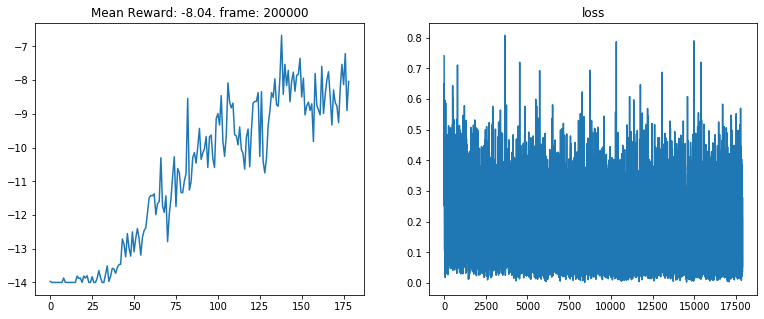

In [15]:
frame_idx = 0
all_rewards = []
losses = []

while frame_idx < max_frames:
    state, goal = env.reset()
    done = False
    episode = []
    total_reward = 0
    while not done:
        action = get_action(model, state, goal)
        next_state, reward, done, _ = env.step(action)
        episode.append((state, reward, done, next_state, goal))
        replay_buffer.push(state, action, reward, next_state, done, goal)
        state = next_state
        total_reward += reward
        frame_idx += 1
        
        if frame_idx % 10000 == 0:
            plot(frame_idx, [np.mean(all_rewards[i:i+100]) for i in range(0, len(all_rewards), 100)], losses)
        
    all_rewards.append(total_reward)
    
    
    new_episode = []
    for state, reward, done, next_state, goal in episode:
        for t in np.random.choice(num_bits, new_goals):
            try:
                episode[t]
            except:
                continue
            new_goal = episode[t][-2]
            if np.sum(next_state == new_goal) == num_bits:
                reward = 0
            else:
                reward = -1
            replay_buffer.push(state, action, reward, next_state, done, new_goal)
            new_episode.append((state, reward, done, next_state, new_goal))
    
    
    
    loss = compute_td_error(batch_size)
    if loss is not None: losses.append(loss.data.item())